In [ ]:
%load_ext autoreload
%autoreload 2
%cd ..

/storage/ducpm/lung-segmentation


In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import f1_score

from tqdm.notebook import tqdm

from src.models import UNet
from src.metrics import dice_coeff_vectorized
from src.data import KmaderDataModule
from src.data.preprocess import extract_mask_lungs
from src.visualization import plot_batch, plot_true_vs_pred

In [10]:
data_module_args = {                                                                                                                                              
   "batch_size": 16,
   "img_size": 512,
   "clip_low": -512,
   "clip_high": 512,
   "invert_lungs": False,
   "pin_memory": True,
   "num_workers": 4
}              
dm = KmaderDataModule(**data_module_args)
dm.setup()

Loading CT scans: 100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


In [11]:
[len(ds) for ds in [dm.train_ds, dm.val_ds, dm.test_ds]]

[725, 182, 301]

In [12]:
device = "cuda:0"
net = UNet.load_from_checkpoint("models/unet-kmader-512-epoch=35-dice_coeff_val=0.998.ckpt")
net = net.eval().to(device)

In [16]:
flat_y_true = []
flat_y_pred = []
# USING LUNG MASKS
test_dsc = []
pbar = tqdm(dm.test_dataloader())
for batch in pbar:
    with torch.no_grad():
        pred_logits = net(batch["img"].to(device))
        pred_masks = torch.argmax(pred_logits, dim=1)
        
    # convert around-lungs mask to lungs mask 
    pred_a_lungs = pred_masks.to("cpu")
    pred_lungs = np.array([extract_mask_lungs(mask) for mask in pred_a_lungs])
    pred_lungs = torch.from_numpy(pred_lungs)

    dsc = dice_coeff_vectorized(pred_lungs, batch["mask"])
    pbar.set_description(f"DSC={dsc:.3f}")
    test_dsc.append(dsc.item())
    
    flat_y_true.append(batch["mask"].cpu().numpy().flatten())
    flat_y_pred.append(pred_lungs.numpy().flatten())
    
flat_y_true = np.concatenate(flat_y_true)
flat_y_pred = np.concatenate(flat_y_pred)
np.mean(test_dsc)

0.8133081019943518

In [17]:
f1_score(flat_y_true, flat_y_pred, labels=None, average='binary')

0.9838053077422914

In [7]:
# USING AROUND LUNGS MASKS
test_dsc = []
pbar = tqdm(dm.test_dataloader())
for batch in pbar:
    with torch.no_grad():
        pred_logits = net(batch["img"].to(device))
        pred_masks = torch.argmax(pred_logits, dim=1)
    dsc = dice_coeff_vectorized(pred_masks, batch["mask"].to(device))
    pbar.set_description(f"DSC={dsc:.3f}")
    test_dsc.append(dsc.item())
np.mean(test_dsc)

0.9937512968715868

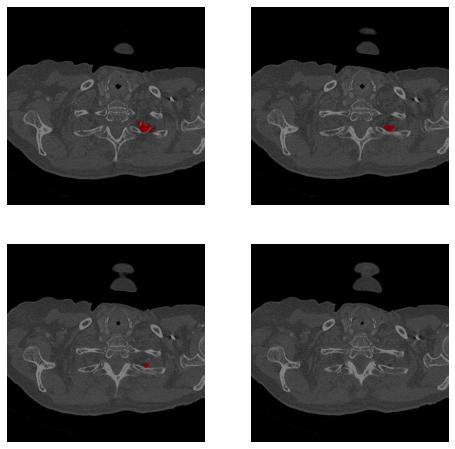

In [11]:
# GROUND TRUTH 
plot_batch(batch["img"], batch["mask"], nrows=2, ncols=2, figsize=(8, 8),
           mask_alpha=0.5)

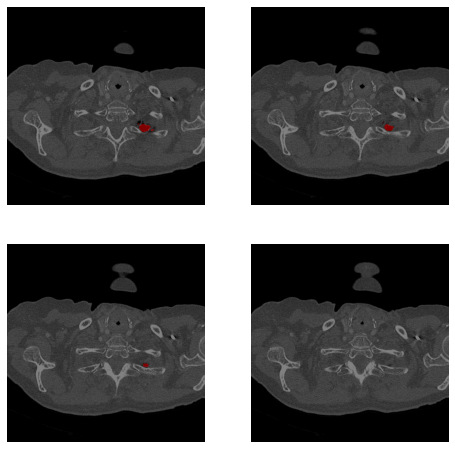

In [10]:
plot_batch(batch["img"], pred_lungs, nrows=2, ncols=2, figsize=(8, 8),
           mask_alpha=0.5)

In [75]:
dice_coeff_vectorized(pred_lungs, 
                      batch["mask"])

tensor(0.7368)

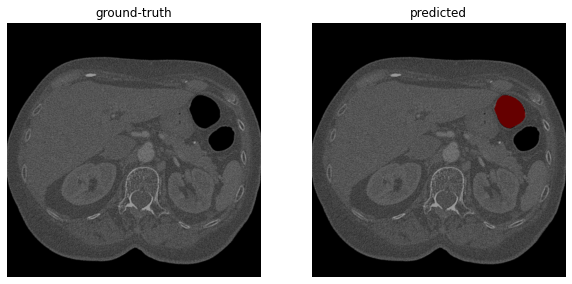

In [90]:
plot_true_vs_pred(batch["img"][-1:], 
                  batch["mask"][-1:], pred_lungs[-1:], mask_alpha=0.4)

In [86]:
batch["img"][-1:].shape

torch.Size([1, 1, 512, 512])